In [121]:
import pandas as pd
import numpy as np
import datetime
from scipy.stats import variation
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.metrics import r2_score, mean_absolute_error
rcParams['figure.figsize'] = 10,10
from scipy.spatial.distance import cdist
from fuzzywuzzy import fuzz
import re
import sys
import pickle as pkl 
from tqdm import tnrange, tqdm_notebook
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct
from sparse_dot_topn import awesome_cossim_topn
from sklearn.metrics.pairwise import cosine_similarity
import time

### Load the NCC Data

In [2]:
ncc = pd.read_csv('../data/NCC_2018_nutrients_per_100g_originalcolnames.txt',sep='\t')

Set Food ID as the index

In [3]:
# ncc['Food ID'].is_unique

In [4]:
# ncc = ncc.set_index('Food ID')

In [5]:
ncc = ncc.rename(columns={'Food ID':'NCC Food ID'})

### Load the data from the ASA24 Recalls

In [6]:
asa_24 = pd.read_csv('../data/training_for_GS_122118.csv')

Set FoodCode as the index 

In [7]:
# asa_24 = asa_24.set_index('FoodCode')

### Load the file listing matching columns between the datasets

In [8]:
matching = pd.read_csv('../data/matching_ncc_fndds_columns.txt',sep='\t')

Get the list of columns for each dataset

In [9]:
ncc_cols = matching['NCC.Term'].values.tolist()
asa_24_cols = matching['FNDDS.Term'].values.tolist()
asa_24_cols = [val.replace(" ","") for val in asa_24_cols]

### Calculate the pairwise correlations
Define a function to calculate the pairwise PCC matrix between two matrices A and B

In [10]:
def row_corr(A,B):
    #number of columns in A or B
    N = B.shape[1]

    # Store row-wise sums of A and B, as they would be used at few places
    sA = A.sum(1)
    sB = B.sum(1)

    # Compute the four terms in pcc matrix-wise
    p1 = N*np.einsum('ik,jk->ij',A,B)
    p2 = sB*sA[:,None]
    p3 = N*((B**2).sum(1)) - (sB**2)
    p4 = N*((A**2).sum(1)) - (sA**2)

    # compute pcc as 2D array 
    pcorr = ((p1 - p2)/np.sqrt(p3*p4[:,None]))
    return pcorr

Get the columns provided by the `matching` file

In [11]:
A = asa_24.loc[:,asa_24_cols].values
B = ncc.loc[:,ncc_cols].values

In [12]:
corr = row_corr(A,B)

/home/gsimmons/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/gsimmons/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


### Calculate weighted pairwise correlations

Load the weights from the Lasso model

In [13]:
# lasso_coef = pd.read_csv('lasso_coef.csv')
# weights = lasso_coef.loc[:,'coef'].values[:-1] #omit 'year'

Define a function to calculate weighted row-wise PCC

In [14]:
# def row_corr_weighted(A,B,weights):
# # converted to python from here: https://stackoverflow.com/questions/9460664/weighted-pearsons-correlation
#     w = weights/sum(weights)
    
#     A = A - (A*w).sum(1)[:,None]
#     B = B - (B*w).sum(1)[:,None]
    
#     pcorr = np.matmul(A,((B*w).T))/np.sqrt(np.matmul(((A**2)*w).sum(1)[:,None],(((B**2)*w).sum(1)[:,None]).T))
#     return pcorr

In [15]:
# corr_weighted = row_corr_weighted(A,B,weights)

### Calculate similarity between labels

#### Min Edit Distance

In [131]:
A_labels = asa_24.Food_Description.values

B_labels = ncc['Short Food Description'].values

A_labels = [re.sub('[.,\/#!$%\^&\*;:{}=\-_`~()]','',label).lower() for label in A_labels]
B_labels = [re.sub('[.,\/#!$%\^&\*;:{}=\-_`~()]','',label).lower() for label in B_labels]

In [134]:
all_labels = A_labels + B_labels

In [127]:
# total = len(A_labels)*len(B_labels)
# lev_sim = np.zeros((len(A_labels),len(B_labels)))
# for i in tnrange(0,len(A_labels)):
#     for j in tqdm_notebook(range(i+1,len(B_labels)),leave=False):
#         lev_sim[i,j] = fuzz.partial_token_sort_ratio(A_labels[i],B_labels[j])
        
# lev_sim = cdist(A_labels.reshape(-1,1),B_labels.reshape(-1,1), fuzz.partial_token_sort_ratio)

# lev_sim = lev_sim / 100

https://bergvca.github.io/2017/10/14/super-fast-string-matching.html

In [113]:
def ngrams(string, n=3):
    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

In [135]:
vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams)
vectorizer.fit(all_labels)
tf_idf_A = vectorizer.transform(A_labels)
tf_idf_B = vectorizer.transform(B_labels)

In [136]:
tf_idf_A

<378x5212 sparse matrix of type '<class 'numpy.float64'>'
	with 13453 stored elements in Compressed Sparse Row format>

In [137]:
tf_idf_B

<17631x5212 sparse matrix of type '<class 'numpy.float64'>'
	with 601729 stored elements in Compressed Sparse Row format>

In [138]:
pd.DataFrame(cosine_similarity(tf_idf_A,tf_idf_B))

,0,1,2,3,4,5,6,7,8,9,...,17621,17622,17623,17624,17625,17626,17627,17628,17629,17630
0,0.053378,0.020130,0.028255,0.079088,0.019436,0.019124,0.038438,0.021219,0.019205,0.018922,...,0.094818,0.141395,0.187138,0.000000,0.000000,0.000000,0.046299,0.083698,0.088542,0.068224
1,0.043537,0.013799,0.000000,0.168768,0.016445,0.000000,0.054561,0.000000,0.000000,0.000000,...,0.120466,0.148003,0.224107,0.208827,0.016631,0.000000,0.122982,0.068815,0.105426,0.062016
2,0.000000,0.000000,0.000000,0.153848,0.000000,0.000000,0.013318,0.000000,0.045262,0.044594,...,0.029158,0.043481,0.247136,0.000000,0.000000,0.000000,0.300340,0.056726,0.057317,0.058442
3,0.000000,0.000000,0.013238,0.142993,0.009106,0.026522,0.023988,0.000000,0.000000,0.008866,...,0.018670,0.015414,0.000000,0.000000,0.022829,0.000000,0.000000,0.149036,0.167091,0.153543
4,0.026055,0.010480,0.023272,0.033513,0.050178,0.054860,0.098348,0.048352,0.050036,0.060461,...,0.081675,0.121795,0.118592,0.039619,0.000000,0.000000,0.011677,0.026583,0.049873,0.041327
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.039115,0.000000,0.031382,0.000000,0.017353,0.017074,0.027607,0.018945,0.017147,0.016894,...,0.038588,0.057544,0.038103,0.026280,0.027021,0.000000,0.000000,0.012471,0.026815,0.012849
7,0.008600,0.017479,0.000000,0.000000,0.013668,0.013449,0.051953,0.014922,0.013506,0.013307,...,0.030395,0.045325,0.030012,0.020699,0.021283,0.000000,0.000000,0.009823,0.021121,0.010120
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.011325,0.000000,0.000000,0.177602,0.186189,...,0.065810,0.080250,0.044216,0.267068,0.027781,0.000000,0.000000,0.011129,0.022096,0.011465
9,0.061320,0.041378,0.000000,0.000000,0.000000,0.020281,0.026194,0.000000,0.000000,0.020066,...,0.106006,0.007136,0.006919,0.000000,0.000000,0.025579,0.000000,0.024783,0.025042,0.025533


In [117]:
t1 = time.time()

SIM_THRESH = 0
N_MATCHES = 10

matches = awesome_cossim_topn(tf_idf_A, tf_idf_B, N_MATCHES, SIM_THRESH)
t = time.time()-t1
print("SELFTIMED:", t)

SELFTIMED: 0.009792566299438477


In [118]:
matches

<378x5185 sparse matrix of type '<class 'numpy.float64'>'
	with 3780 stored elements in Compressed Sparse Row format>

In [119]:
def get_matches_df(sparse_matrix, A_labels, B_labels, top=10):
    non_zeros = sparse_matrix.nonzero()
    
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]
    
    print(sparserows)
    print(sparsecols)
#     if top:
#         nr_matches = top
#     else:
#         nr_matches = sparsecols.size

    nr_matches = 10
    
    left_side = np.empty([nr_matches], dtype=object)
    right_side = np.empty([nr_matches], dtype=object)
    similairity = np.zeros(nr_matches)
    
    for index in range(0, nr_matches):
        a = sparserows[index]
        left_side[index] = A_labels[a]
        b = sparsecols[index]
        right_side[index] = B_labels[b]
        similairity[index] = sparse_matrix.data[index]
    
    return pd.DataFrame({'left_side': left_side,
                          'right_side': right_side,
                           'similairity': similairity})

In [120]:
matches_df = get_matches_df(matches, A_labels, B_labels, top=100000)
matches_df = matches_df[matches_df['similairity'] < 0.99999] # Remove all exact matches
matches_df

[  0   0   0 ... 377 377 377]
[ 726  947 4099 ... 2426 1282 4069]


,left_side,right_side,similairity
0,milk condensed sweetened formerly ns as to dil...,happy baby organic creamies carrot mango orange,0.293713
1,milk condensed sweetened formerly ns as to dil...,enfamil nutramigen with enflora lgg prepared ...,0.268025
2,milk condensed sweetened formerly ns as to dil...,feta cheese,0.261862
3,milk condensed sweetened formerly ns as to dil...,veryfine orange strawberry,0.247592
4,milk condensed sweetened formerly ns as to dil...,sprite,0.247425
5,milk condensed sweetened formerly ns as to dil...,natural granola oats honey quaker,0.231303
6,milk condensed sweetened formerly ns as to dil...,veryfine pink grapefruit,0.231176
7,milk condensed sweetened formerly ns as to dil...,baby food animal crackers cinnamon,0.221321
8,milk condensed sweetened formerly ns as to dil...,pinole prepared with water pima indian,0.213335
9,milk condensed sweetened formerly ns as to dil...,beechnut quinoa crispies vanilla,0.211015


### Store the label similarity matrix because it takes a while to recompute

In [ ]:
with open('lev_sim.pkl', 'wb') as f:
    pkl.dump(lev_sim, f)

### Get results (unweighted)

In [ ]:
Combine the string matching similarity and PCC

In [ ]:
# combined_sim = lev_sim + corr
combined_sim = np.minimum(lev_sim,corr)

Get indices of the top matches from the correlation matrix

In [58]:
TOP = 5 # set the number of matches to return

indices_top = np.argsort(-corr,axis=1,)[:,:TOP]
pcc_top = np.sort(-corr,axis=1,)[:,:TOP]

Construct dataframe to store top results

In [59]:
iters = [np.arange(0,asa_24.shape[0],1).tolist(),np.arange(0,TOP,1).tolist()]

results_cols = asa_24.columns.values.tolist() + ['PCC'] + ncc.columns.values.tolist()

mi = pd.MultiIndex.from_product(iters, names=['asa_index', 'match_index'])

results_top = pd.DataFrame(index=mi,columns=results_cols)

Copy ASA24 values to left side

In [60]:
results_top.loc[results_top.eval('match_index==0'), asa_24.columns] = asa_24.values

results_top.loc[:,ncc.columns] = ncc.iloc[indices_top.flatten(),:].values

results_top.loc[:,'PCC'] = -pcc_top.flatten()

In [61]:
variations = pd.DataFrame(results_top['Lactose (g)'].groupby("asa_index").apply(variation))

/software/anaconda3/4.5.12/lssc0-linux/lib/python3.6/site-packages/scipy/stats/stats.py:1025: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis) / a.mean(axis)


In [62]:
for index in results_top.index.get_level_values(0).unique():
    results_top.loc[index,'variation'] = variations.loc[index,:].values[0]

### Save results to CSV

In [63]:
name = 'pcc_matching_results_top_{}.tsv'.format(TOP)
path = '../data/' + name
results_top.to_csv(path,sep='\t')

In [64]:
desc_only_cols = ['FoodCode','Food_Description','year','PCC','NCC Food ID','Keylist','Food Description','Short Food Description','Food Type','Lactose (g)','variation']

In [65]:
results_top_desc_only = results_top[desc_only_cols]

In [66]:
name = 'pcc_matching_results_top_{}_desc_only.tsv'.format(TOP)
path = '../data/' + name
results_top_desc_only.to_csv(path,sep='\t')

### Get results (weighted)

Get indices of the top matches from the correlation matrix

In [67]:
TOP = 5 # set the number of matches to return

indices_top = np.argsort(-corr_weighted,axis=1,)[:,:TOP]
pcc_top = np.sort(-corr_weighted,axis=1,)[:,:TOP]

Construct dataframe to store top results

In [68]:
iters = [np.arange(0,asa_24.shape[0],1).tolist(),np.arange(0,TOP,1).tolist()]

results_cols = asa_24.columns.values.tolist() + ['Weighted PCC'] + ncc.columns.values.tolist()

mi = pd.MultiIndex.from_product(iters, names=['asa_index', 'match_index'])

results_top = pd.DataFrame(index=mi,columns=results_cols)

Copy ASA24 values to left side

In [69]:
results_top.loc[results_top.eval('match_index==0'), asa_24.columns] = asa_24.values

results_top.loc[:,ncc.columns] = ncc.iloc[indices_top.flatten(),:].values

results_top.loc[:,'Weighted PCC'] = -pcc_top.flatten()

In [70]:
variations = pd.DataFrame(results_top['Lactose (g)'].groupby("asa_index").apply(variation))

In [71]:
for index in results_top.index.get_level_values(0).unique():
    results_top.loc[index,'variation'] = variations.loc[index,:].values[0]

### Save results to CSV

In [72]:
name = 'pcc_matching_results_top_{}_weighted.tsv'.format(TOP)
path = '../data/' + name
results_top.to_csv(path,sep='\t')

In [73]:
results_top_desc_only = results_top[['Weighted PCC' if col == 'PCC' else col for col in desc_only_cols]]

In [74]:
name = 'pcc_matching_results_top_{}_weighted_desc_only.tsv'.format(TOP)
path = '../data/' + name
results_top_desc_only.to_csv(path,sep='\t')

### Load the data back in
(Check that it was saved, further analysis, etc.)

In [2]:
results_top_desc_only_w =  pd.read_csv('../data/pcc_matching_results_top_5_weighted_desc_only.tsv',sep='\t')

In [76]:
results_top_w = pd.read_csv('../data/pcc_matching_results_top_5_weighted.tsv',sep='\t')
results_top = pd.read_csv('../data/pcc_matching_results_top_5.tsv',sep='\t')

In [3]:
results_top_desc_only =  pd.read_csv('../data/pcc_matching_results_top_5_desc_only.tsv',sep='\t')

Calculate MAE between dietitian labels and our lookup results

In [153]:
labeled_lactose = results_top.loc[:,'lac.per.100g']
labeled_lactose = labeled_lactose[~np.isnan(labeled_lactose)].values.flatten()

lookup_lactose = pd.DataFrame(results_top['Lactose (g)'].groupby("asa_index").apply(np.mean)).values.flatten()
labeled_lactose_nonzero = labeled_lactose[labeled_lactose != 0]
lookup_lactose_nonzero = lookup_lactose[labeled_lactose != 0]

KeyError: 'asa_index'

In [145]:
def mean_absolute_percentage_error(y_true, y_pred): 

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [144]:
np.mean(lookup_lactose_nonzero)

2.150474226804124

In [147]:
print('MAE: {}'.format(mean_absolute_error(labeled_lactose,lookup_lactose)))
print('MAPE: {}'.format(mean_absolute_percentage_error(labeled_lactose_nonzero,lookup_lactose_nonzero)))
print('R2: {}'.format(r2_score(labeled_lactose,lookup_lactose)))

MAE: 1.0133881481481484
MAPE: 1994.282418854255
R2: 0.09914837462619741


Text(0.5, 1.0, 'Dietitian selected vs Top 5 PCC Match Average Values\n lactose g/100g')

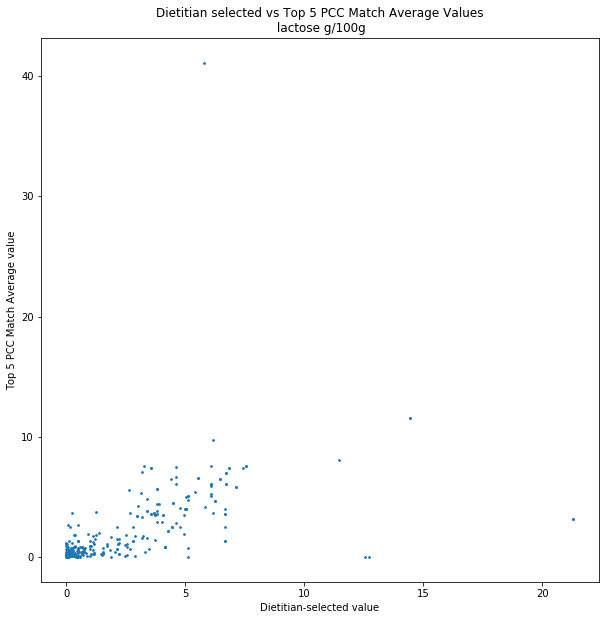

In [141]:
plt.scatter(x=labeled_lactose[labeled_lactose != 0],y=lookup_lactose[labeled_lactose != 0],s=3)
plt.xlabel('Dietitian-selected value')
plt.ylabel('Top 5 PCC Match Average value')
plt.title('Dietitian selected vs Top 5 PCC Match Average Values\n lactose g/100g')

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 1401 while Y.shape[1] == 17631